# GRU Prediction

In [1]:
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
df_weather_stations = pd.read_csv('..\data\ceops_v1\estacoes_eventos_nivel_rio_v0.csv', parse_dates=['data_hora'])

In [3]:
df_weather_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19018 entries, 0 to 19017
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   data_hora        19018 non-null  datetime64[ns]
 1   n_blumenau       19018 non-null  float64       
 2   c_blumenau       19018 non-null  float64       
 3   n_apiuna         19018 non-null  float64       
 4   c_apiuna         19018 non-null  float64       
 5   n_ibirama        19018 non-null  float64       
 6   c_ibirama        19018 non-null  float64       
 7   c_indaial        19018 non-null  float64       
 8   n_ituporanga     19018 non-null  float64       
 9   c_ituporanga     19018 non-null  float64       
 10  c_pouso_redondo  19018 non-null  float64       
 11  c_rio_do_oeste   19018 non-null  float64       
 12  n_rio_do_sul     19018 non-null  float64       
 13  c_rio_do_sul     19018 non-null  float64       
 14  n_taio           19018 non-null  float

In [4]:
df_weather_stations.filter(regex='c_.*').max()

c_blumenau         18.54
c_apiuna           16.20
c_ibirama          15.40
c_indaial          17.53
c_ituporanga       46.74
c_pouso_redondo    24.38
c_rio_do_oeste     17.53
c_rio_do_sul       16.76
c_taio             27.94
c_timbo            17.53
dtype: float64

In [5]:
df_weather_stations.filter(regex='n_.*').max()

n_blumenau      10.510
n_apiuna         8.050
n_ibirama        4.677
n_ituporanga     5.842
n_rio_do_sul    10.820
n_taio          10.950
n_timbo         11.780
n_blumenau_3    10.510
n_blumenau_6    10.510
n_blumenau_9    10.510
dtype: float64

In [6]:
max_rain = 50
min_rain = 0

max_river_level = 17
min_river_level = 0

df_weather_stations_norm = df_weather_stations.copy()
for rain_column in df_weather_stations.filter(regex='c_.*').columns:
    df_weather_stations_norm[rain_column] = (df_weather_stations[rain_column] - min_rain) / (max_rain - min_rain)

for river_column in df_weather_stations.filter(regex='n_.*').columns:
    df_weather_stations_norm[river_column] = (df_weather_stations[river_column] - min_river_level) / (max_river_level - min_river_level)

In [7]:
df_weather_stations_norm.max()

data_hora          2019-06-04 16:00:00
n_blumenau                    0.618235
c_blumenau                      0.3708
n_apiuna                      0.473529
c_apiuna                         0.324
n_ibirama                     0.275118
c_ibirama                        0.308
c_indaial                       0.3506
n_ituporanga                  0.343647
c_ituporanga                    0.9348
c_pouso_redondo                 0.4876
c_rio_do_oeste                  0.3506
n_rio_do_sul                  0.636471
c_rio_do_sul                    0.3352
n_taio                        0.644118
c_taio                          0.5588
n_timbo                       0.692941
c_timbo                         0.3506
n_blumenau_3                  0.618235
n_blumenau_6                  0.618235
n_blumenau_9                  0.618235
numero_evento                       34
dtype: object

In [8]:
df_weather_stations.head()

,data_hora,n_blumenau,c_blumenau,n_apiuna,c_apiuna,n_ibirama,c_ibirama,c_indaial,n_ituporanga,c_ituporanga,...,n_rio_do_sul,c_rio_do_sul,n_taio,c_taio,n_timbo,c_timbo,n_blumenau_3,n_blumenau_6,n_blumenau_9,numero_evento
0,2009-01-18 22:15:00,1.895,0.0,0.832,0.0,1.645,0.0,0.0,0.853,0.0,...,5.436,0.0,5.705,0.0,2.376,0.0,1.833,1.743,1.742,1
1,2009-01-18 22:30:00,1.893,0.0,0.831,0.0,1.653,0.0,0.0,0.845,0.0,...,5.436,0.0,5.705,0.0,2.376,0.0,1.825,1.740,1.746,1
2,2009-01-18 22:45:00,1.890,0.0,0.831,0.0,1.649,0.0,0.0,0.843,0.0,...,5.436,0.0,5.705,0.0,2.376,0.0,1.816,1.736,1.751,1
3,2009-01-18 23:00:00,1.887,0.0,0.832,0.0,1.653,0.0,0.0,0.838,0.0,...,5.436,0.0,5.705,0.0,2.376,0.0,1.808,1.733,1.755,1
4,2009-01-18 23:15:00,1.882,0.0,0.831,0.0,1.654,0.0,0.0,0.832,0.0,...,5.436,0.0,5.705,0.0,2.376,0.0,1.798,1.735,1.767,1


In [9]:
df_weather_stations.groupby(df_weather_stations.numero_evento).size().reset_index(name='count')

,numero_evento,count
0,1,282
1,2,460
2,3,330
3,4,622
4,5,351
5,6,304
6,7,464
7,8,784
8,9,280
9,10,301


In [10]:
SEED = 12345678
torch.manual_seed(SEED)

In [11]:
#TODO ter uma sequência das 24 horas anteriores para cada observação para tentar prever o alvo de 3, 6 ou 9 horas no futuro
# Para isso não deve-se utilizar as primeiras 24 de cada evento selecionado dos dados iniciais
# Depois devemos misturar casos de situação normal e em atenção, com em alerta e enchente para termos distribuições uniformes de cada tipo de situação atual nas divisões de treino, desenvolvimento e teste

In [12]:
number_of_events = df_weather_stations.numero_evento.loc[df_weather_stations.numero_evento.idxmax()]
print(f"Numero de eventos: {number_of_events}")

number_of_train_events = round(number_of_events * 75 / 100) #75% dos dados para treino
print(f"Numero de eventos de treino: {number_of_train_events}")

number_of_dev_test_events = int(number_of_events * 12.5 / 100) #12,5% dos dados para desenvolvimento e teste
print(f"Numero de eventos de devenvolvimento/teste: {number_of_dev_test_events}")
#Maior proporção para dados de desenvolvimento e teste em datasets menores

Numero de eventos: 34
Numero de eventos de treino: 26
Numero de eventos de devenvolvimento/teste: 4


In [13]:
number_of_train_events = 26
number_of_dev_events = 4
number_of_test_events = 2

In [14]:
all_data = df_weather_stations.iloc[:, 1:-1].to_numpy()
# all_data = df_weather_stations_norm.iloc[:, 1:-1].to_numpy()

In [15]:
all_data[0, :]

array([1.895, 0.   , 0.832, 0.   , 1.645, 0.   , 0.   , 0.853, 0.   ,
       0.   , 0.   , 5.436, 0.   , 5.705, 0.   , 2.376, 0.   , 1.833,
       1.743, 1.742])

In [63]:
registers_interval_over_flood_events = 24 * 4 #4 registros por hora por 24 horas
valid_data_ranges = []
for i in range(1, number_of_events + 1):
    start_valid_range = df_weather_stations.numero_evento.where(df_weather_stations.numero_evento == i).first_valid_index() + registers_interval_over_flood_events
    end_valid_range = len(df_weather_stations) if i == number_of_events else df_weather_stations.numero_evento.where(df_weather_stations.numero_evento == i + 1).first_valid_index()
    valid_data_ranges.append((start_valid_range, end_valid_range))

In [64]:
valid_data_ranges

[(96, 282),
 (378, 742),
 (838, 1072),
 (1168, 1694),
 (1790, 2045),
 (2141, 2349),
 (2445, 2813),
 (2909, 3597),
 (3693, 3877),
 (3973, 4178),
 (4274, 4477),
 (4573, 5102),
 (5198, 5656),
 (5752, 6000),
 (6096, 6636),
 (6732, 6999),
 (7095, 7574),
 (7670, 7853),
 (7949, 8112),
 (8208, 9207),
 (9303, 9605),
 (9701, 9858),
 (9954, 10992),
 (11088, 11646),
 (11742, 12092),
 (12188, 14358),
 (14454, 14805),
 (14901, 15281),
 (15377, 15588),
 (15684, 16125),
 (16221, 16456),
 (16552, 18052),
 (18148, 18459),
 (18555, 19018)]

In [65]:
valid_data_mask = []
for i in range(len(df_weather_stations)):
    mask_value = False
    for valid_data_range in valid_data_ranges:
        start_valid_range = valid_data_range[0]
        end_valid_range = valid_data_range[1]
        if start_valid_range <= i < end_valid_range:
            mask_value = True
            break
    valid_data_mask.append(mask_value)

In [66]:
valid_data = df_weather_stations.iloc[valid_data_mask, 1:].to_numpy()
# valid_data = df_weather_stations_norm.iloc[valid_data_mask, 1:].to_numpy()

In [67]:
print(f"Tamanho de todos os dados: {len(all_data)}")
print(f"Tamanho de todos os dados validos: {len(valid_data)}")
print(len(all_data) - len(valid_data))
print(registers_interval_over_flood_events * number_of_events)

Tamanho de todos os dados: 19018
Tamanho de todos os dados validos: 15754
3264
3264


In [68]:
all_data.shape

(19018, 20)

In [69]:
train_all_data_offset = df_weather_stations.numero_evento.where(df_weather_stations.numero_evento == number_of_train_events + 1).first_valid_index()
train_valid_data_offset = train_all_data_offset - number_of_train_events * registers_interval_over_flood_events
print(f"Offset dos dados de treino: {train_all_data_offset}")
print(f"Offset dos dados validos de treino: {train_valid_data_offset}")

dev_all_data_offset = df_weather_stations.numero_evento.where(df_weather_stations.numero_evento == number_of_train_events + number_of_dev_events + 1).first_valid_index()
dev_valid_data_offset = dev_all_data_offset - (number_of_train_events + number_of_dev_events) * registers_interval_over_flood_events
print(f"Offset dos dados de desenvolvimento: {dev_all_data_offset}")
print(f"Offset dos dados validos de desenvolvimento: {dev_valid_data_offset}")

test_all_data_offset = df_weather_stations.numero_evento.where(df_weather_stations.numero_evento == number_of_train_events + number_of_dev_events + number_of_test_events + 1).first_valid_index()
test_valid_data_offset = test_all_data_offset - (number_of_train_events + number_of_dev_events + number_of_test_events) * registers_interval_over_flood_events
print(f"Offset dos dados de teste: {test_all_data_offset}")
print(f"Offset dos dados validos de teste: {test_valid_data_offset}")

train_data = valid_data[:train_valid_data_offset, :]
train_data_all = all_data[:train_all_data_offset, :]
print(f"Dimensões dos dados de treino: {train_data.shape}")
print(f"Dimensões dos dados completos de treino: {train_data_all.shape}")

dev_data = valid_data[train_valid_data_offset:dev_valid_data_offset, :]
dev_data_all = all_data[train_all_data_offset:dev_all_data_offset, :]
print(f"Dimensões dos dados de desenvolvimento: {dev_data.shape}")
print(f"Dimensões dos dados completos de desenvolvimento: {dev_data_all.shape}")

test_data = valid_data[dev_valid_data_offset:test_valid_data_offset, :]
test_data_all = all_data[dev_all_data_offset:test_all_data_offset, :]
print(f"Dimensões dos dados de teste: {test_data.shape}")
print(f"Dimensões dos dados completos de teste: {test_data_all.shape}")

Offset dos dados de treino: 14358
Offset dos dados validos de treino: 11862
Offset dos dados de desenvolvimento: 16125
Offset dos dados validos de desenvolvimento: 13245
Offset dos dados de teste: 18052
Offset dos dados validos de teste: 14980
Dimensões dos dados de treino: (11862, 21)
Dimensões dos dados completos de treino: (14358, 20)
Dimensões dos dados de desenvolvimento: (1383, 21)
Dimensões dos dados completos de desenvolvimento: (1767, 20)
Dimensões dos dados de teste: (1735, 21)
Dimensões dos dados completos de teste: (1927, 20)


In [70]:
valid_data_columns_mask = []
valid_data_columns_size = valid_data.shape[1]
for i in range(valid_data_columns_size):
    valid_data_columns_mask.append(i not in (valid_data_columns_size - 4, valid_data_columns_size - 3, valid_data_columns_size - 2))

In [71]:
test_data[0]

array([ 3.27 ,  0.   ,  3.798,  0.   ,  2.663,  0.   ,  0.   ,  2.406,
        0.254,  0.   ,  0.254,  5.436,  0.508,  5.824,  0.   ,  2.456,
        0.   ,  3.601,  4.045,  4.518, 31.   ])

In [72]:
X_train, X_train_all, y_train_3_hours, y_train_6_hours, y_train_9_hours = (train_data[:, valid_data_columns_mask], train_data_all[:, :-3], train_data[:, [-4]], train_data[:, [-3]], train_data[:, [-2]])
X_dev, X_dev_all, y_dev_3_hours, y_dev_6_hours, y_dev_9_hours = (dev_data[:, valid_data_columns_mask], dev_data_all[:, :-3], dev_data[:, [-4]], dev_data[:, [-3]], dev_data[:, [-2]])
X_test, X_test_all, y_test_3_hours, y_test_6_hours, y_test_9_hours = (test_data[:, valid_data_columns_mask], test_data_all[:, :-3], test_data[:, [-4]], test_data[:, [-3]], test_data[:, [-2]])

In [73]:
# X_train, X_train_all, y_train_3_hours, y_train_6_hours, y_train_9_hours = (train_data[:, valid_data_columns_mask], train_data_all[:, :-3], train_data_all[:, [-3]], train_data_all[:, [-2]], train_data_all[:, [-1]])
# X_dev, X_dev_all, y_dev_3_hours, y_dev_6_hours, y_dev_9_hours = (dev_data[:, valid_data_columns_mask], dev_data_all[:, :-3], dev_data_all[:, [-3]], dev_data_all[:, [-2]], dev_data_all[:, [-1]])
# X_test, X_test_all, y_test_3_hours, y_test_6_hours, y_test_9_hours = (test_data[:, valid_data_columns_mask], test_data_all[:, :-3], test_data_all[:, [-3]], test_data_all[:, [-2]], test_data_all[:, [-1]])

In [74]:
print(X_train.shape)
print(X_train_all.shape)
print(y_train_3_hours.shape)

(11862, 18)
(14358, 17)
(11862, 1)


In [75]:
BATCH_SIZE = 32
FEATURES_SIZE = X_train_all.shape[1]
LEARNING_RATE = 1e-05
N_EPOCHS = 400
N_HIDDEN = 256
N_LAYERS = 1
DROP_PROB = 0.25
SEQUENCE_LENGTH = registers_interval_over_flood_events + 1
HOURS_TO_PREDICT = 3

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CPU_DEVICE = torch.device('cpu')



In [76]:
class FloodPredictionDataset(Dataset):
    def __init__(self, valid_data, all_data, labels, sequence_length=SEQUENCE_LENGTH):
        self.all_data = all_data
        self.sequence_length = sequence_length
        self.X = torch.tensor(valid_data).float().to(DEVICE)
        self.y = torch.tensor(labels).float().to(DEVICE)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        event_number = int(self.X[i, -1].item())

        if event_number <= number_of_train_events:
           deslocated_offset_to_all_data = i + event_number * registers_interval_over_flood_events
        elif event_number <= (number_of_train_events + number_of_dev_test_events):
           deslocated_offset_to_all_data = i + (event_number - number_of_train_events) * registers_interval_over_flood_events
        else:
           deslocated_offset_to_all_data = i + (event_number - number_of_train_events - number_of_dev_test_events) * registers_interval_over_flood_events
            
        start_range = deslocated_offset_to_all_data - registers_interval_over_flood_events

        x = self.all_data[start_range:(deslocated_offset_to_all_data + 1), :]

        return torch.tensor(x).float().to(DEVICE), self.y[i]

In [77]:
train_dataset_prediction = FloodPredictionDataset(
    X_train,
    X_train_all,
    y_train_3_hours
)
train_loader_prediction = DataLoader(train_dataset_prediction, batch_size=BATCH_SIZE, shuffle=False)

In [78]:
dev_dataset_prediction = FloodPredictionDataset(
    X_dev,
    X_dev_all,
    y_dev_3_hours
)
dev_loader_prediction = DataLoader(dev_dataset_prediction, batch_size=BATCH_SIZE, shuffle=False)

In [79]:
test_dataset_prediction = FloodPredictionDataset(
    X_test,
    X_test_all,
    y_test_3_hours
)
test_loader_prediction = DataLoader(test_dataset_prediction, batch_size=BATCH_SIZE, shuffle=False)

In [80]:
X, y = next(iter(train_loader_prediction))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 97, 17])
Target shape: torch.Size([32, 1])


In [81]:
class GRU_prediction(nn.Module):
    
    def __init__(self, features_size, device, n_hidden=N_HIDDEN, n_layers=N_LAYERS, drop_prob=DROP_PROB):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.device = device
        
        gru_drop_prob = drop_prob if n_layers > 1 else 0
        self.gru = nn.GRU(input_size=features_size, hidden_size=n_hidden,  
                            num_layers=n_layers, dropout=gru_drop_prob,
                            batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, 1)
      
    
    def forward(self, x): 
        batch_size = x.shape[0]

        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(self.device) 

        output, hidden = self.gru(x, h0)

        output = self.fc(self.dropout(hidden[0]))
        
        return output

In [82]:
model_prediction = GRU_prediction(features_size=FEATURES_SIZE, device=DEVICE, 
                                    n_hidden=N_HIDDEN, n_layers=N_LAYERS, 
                                    drop_prob=DROP_PROB).to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_prediction.parameters(), lr=LEARNING_RATE)

In [36]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches

In [37]:
def dev_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    return total_loss / num_batches
    

In [1198]:
train_losses = []
dev_losses = []
epochs = range(1, N_EPOCHS + 1)
for epoch in epochs:
    print(f"Epoch {epoch}\n---------")

    train_loss = train_model(train_loader_prediction, model_prediction, loss_function, optimizer=optimizer)
    print(f"Train loss: {train_loss}")
    train_losses.append(train_loss)

    dev_loss = dev_model(dev_loader_prediction, model_prediction, loss_function)
    print(f"Dev loss: {dev_loss}")
    dev_losses.append(dev_loss)

    print()

Epoch 1
---------
Train loss: 19.045320345596835
Dev loss: 10.116757776679062

Epoch 2
---------
Train loss: 11.049914738671346
Dev loss: 4.219093383812323

Epoch 3
---------
Train loss: 4.885510440227915
Dev loss: 0.8433255365078632

Epoch 4
---------
Train loss: 2.234004227762026
Dev loss: 0.49070854308424383

Epoch 5
---------
Train loss: 1.7839581812520258
Dev loss: 0.6407760213379089

Epoch 6
---------
Train loss: 1.6757641895991666
Dev loss: 0.6653586202868964

Epoch 7
---------
Train loss: 1.5762645915065976
Dev loss: 0.6289720883729254

Epoch 8
---------
Train loss: 1.4771831532707438
Dev loss: 0.5898680592682667

Epoch 9
---------
Train loss: 1.3745629479791122
Dev loss: 0.5478890243940419

Epoch 10
---------
Train loss: 1.2924908341850492
Dev loss: 0.5088769624963766

Epoch 11
---------
Train loss: 1.2113977591136724
Dev loss: 0.4784390345760962

Epoch 12
---------
Train loss: 1.139531042797237
Dev loss: 0.4491828719335722

Epoch 13
---------
Train loss: 1.079207059546289
Dev

KeyboardInterrupt: 

In [ ]:
result_header = ['epoch', 'train_loss', 'dev_loss']
result_dir = f"..\\results\\gru\\nine_hours_prediction\\sequence_length\\{SEQUENCE_LENGTH}\\recurrent_layers\\{N_LAYERS}\\hidden_units\\{N_HIDDEN}\\learning_rate\\{LEARNING_RATE}"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

with open(result_dir + f"\\{N_EPOCHS}_epochs_result_batch_size_{BATCH_SIZE}_dropout_{int(DROP_PROB*100)}.csv", 'w', newline='') as result_file:
    result_csv_writer = csv.writer(result_file, delimiter=';')
    result_csv_writer.writerow(result_header)
    for i in range(N_EPOCHS):
        epoch = i + 1
        result_csv_writer.writerow([epoch, train_losses[i], dev_losses[i]])

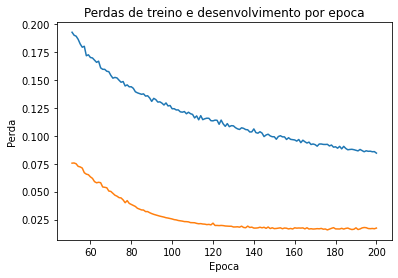

In [ ]:
fig, ax = plt.subplots()
ax.plot(list(epochs[50:]), train_losses[50:])
ax.plot(list(epochs[50:]), dev_losses[50:])
ax.set_title('Perdas de treino e desenvolvimento por epoca')
ax.set_xlabel('Epoca')
ax.set_ylabel('Perda')
plt.show()

In [42]:
def predict(data_loader, model):

    output = torch.tensor([]).to(DEVICE)
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [84]:
# train_predictions = predict(train_loader_prediction, model_prediction).to(CPU_DEVICE).numpy() * (max_river_level - min_river_level) + min_river_level
# dev_predictions = predict(dev_loader_prediction, model_prediction).to(CPU_DEVICE).numpy() * (max_river_level - min_river_level) + min_river_level
train_predictions = predict(train_loader_prediction, model_prediction).to(CPU_DEVICE).numpy()
dev_predictions = predict(dev_loader_prediction, model_prediction).to(CPU_DEVICE).numpy()
test_predictions = predict(test_loader_prediction, model_prediction).to(CPU_DEVICE).numpy()

In [85]:
df_valid_data = df_weather_stations.iloc[valid_data_mask, :]
event_offsets = list(df_valid_data.reset_index().drop_duplicates('numero_evento',keep='first').index)
train_event_offsets = list(df_valid_data.where(df_valid_data.numero_evento <= number_of_train_events).reset_index().drop_duplicates('numero_evento',keep='first').index)

In [86]:
len(train_event_offsets)

27

In [87]:
dates = df_weather_stations.iloc[valid_data_mask, [0]].to_numpy()
train_dates = dates[:train_valid_data_offset, :]


In [88]:
# y_train_3_hours = y_train_3_hours * (max_river_level - min_river_level) + min_river_level

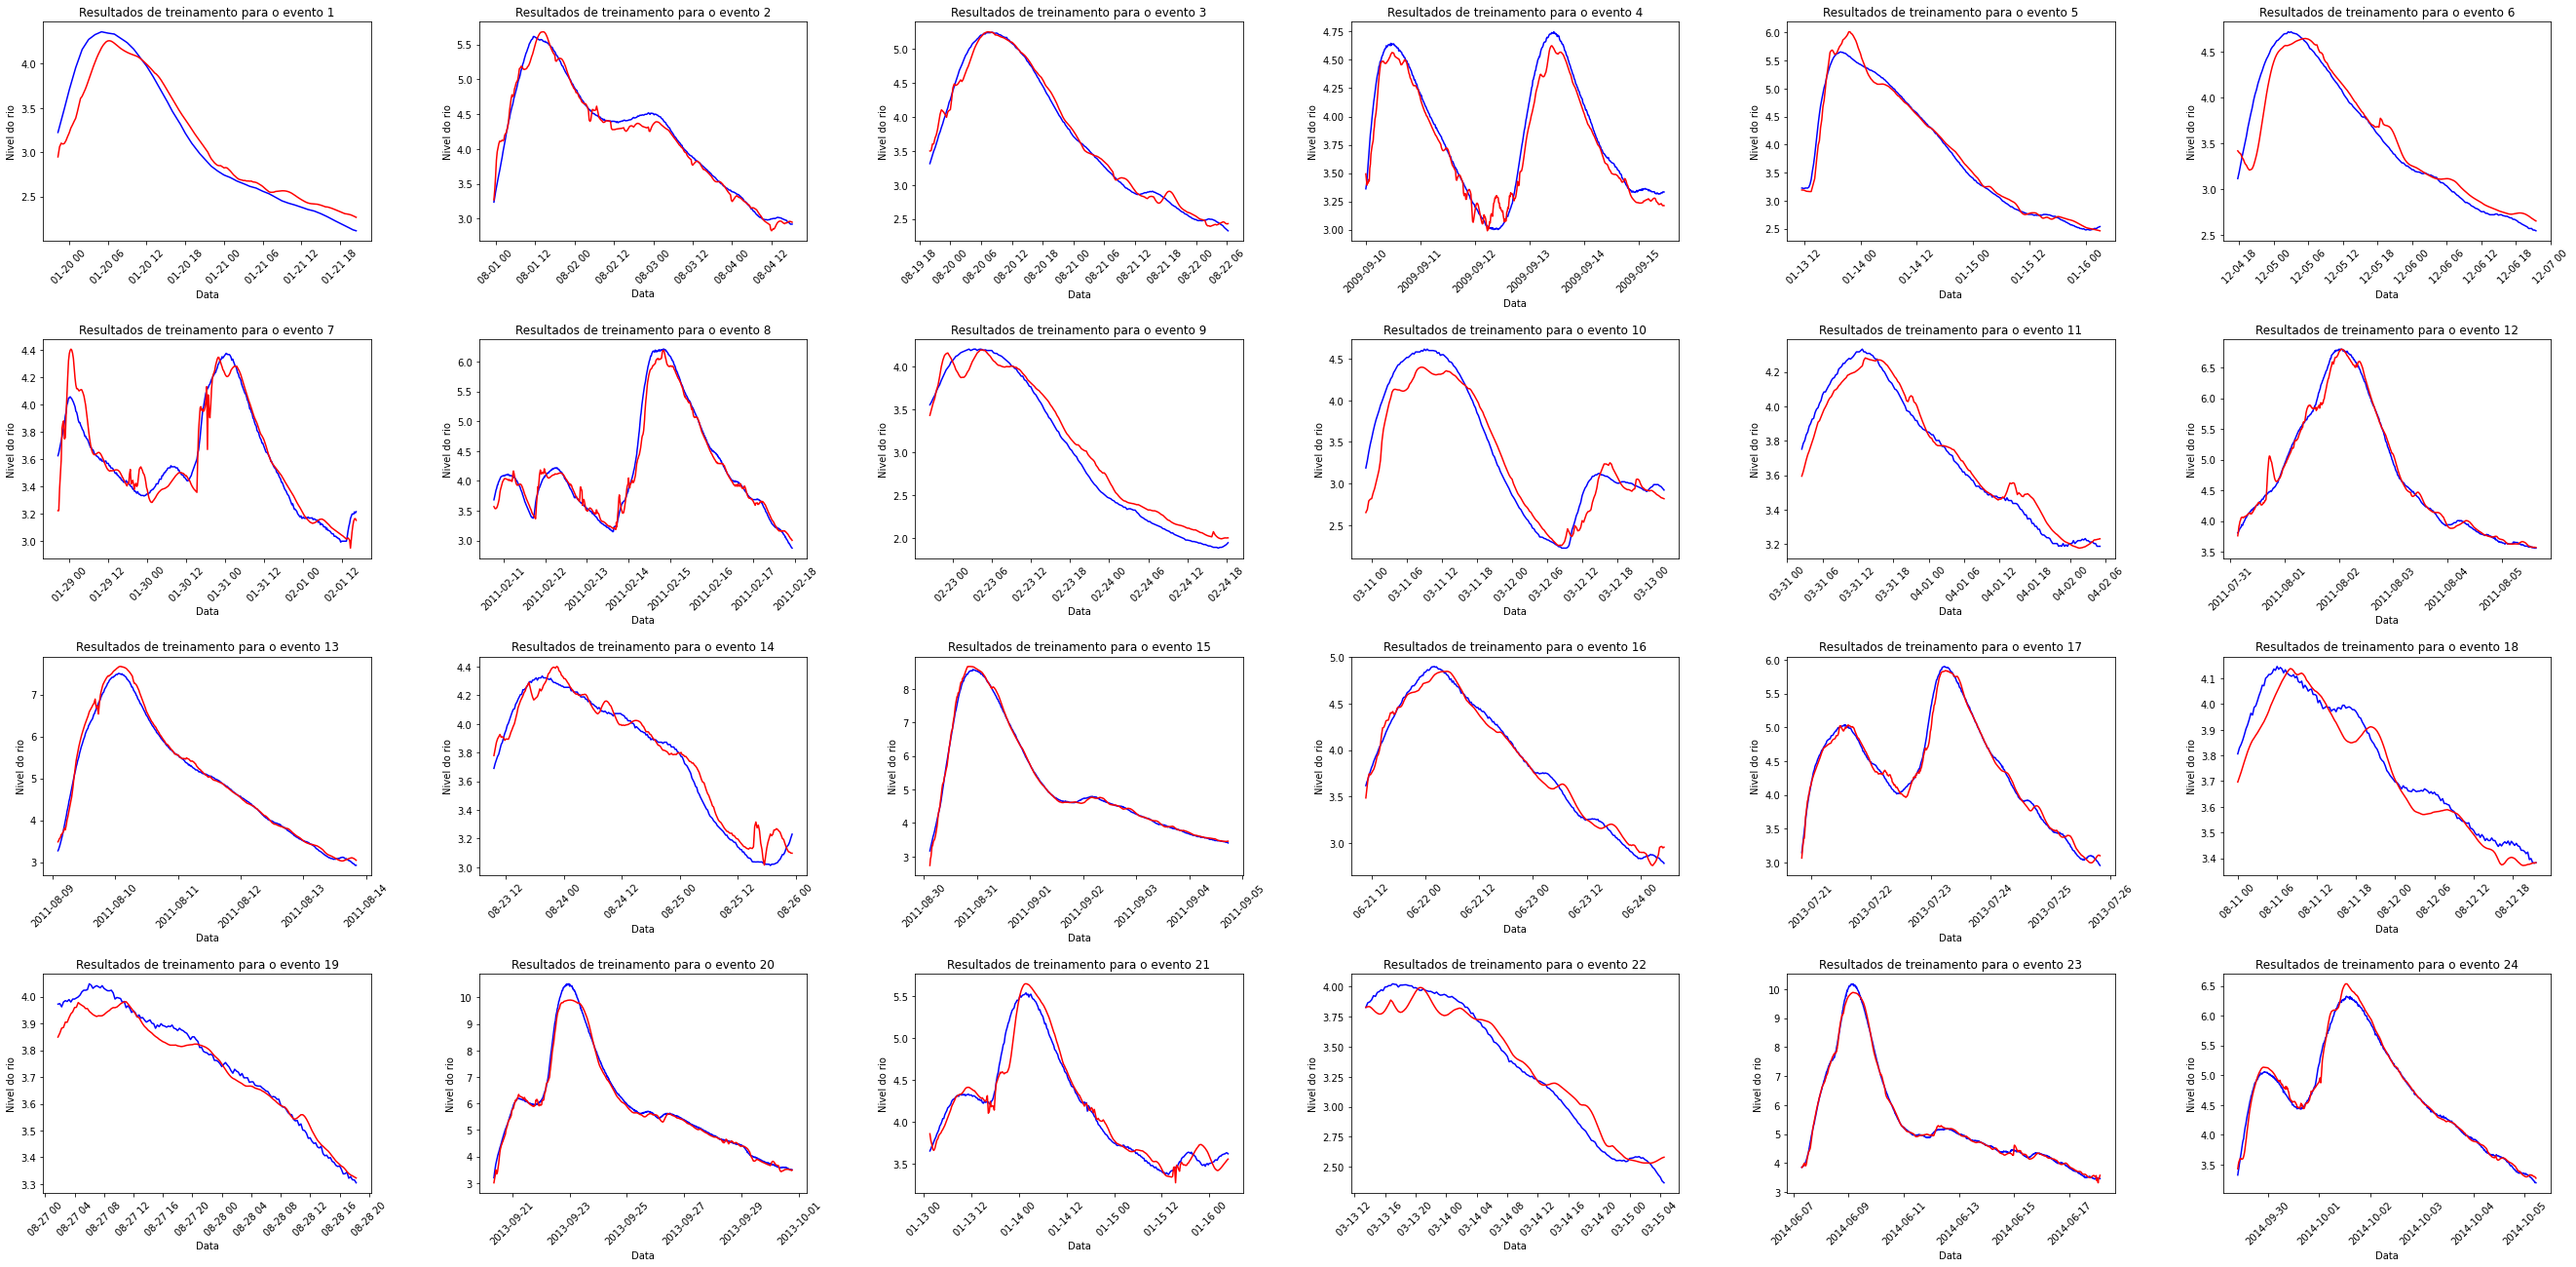

In [89]:
plot_lines = 4
plot_columns = 6
fig, ax = plt.subplots(plot_lines, plot_columns, figsize=(6.4*6, 4.8*4))
fig.tight_layout(pad=8)
for line in range(plot_lines):
    for column in range(plot_columns):
        event = line * plot_columns + column
        ax[line, column].plot(dates[train_event_offsets[event]:train_event_offsets[event+1]], y_train_3_hours[train_event_offsets[event]:train_event_offsets[event+1]], label='Verdadeiras medições', color='Blue')
        ax[line, column].plot(dates[train_event_offsets[event]:train_event_offsets[event+1]], train_predictions[train_event_offsets[event]:train_event_offsets[event+1]], label='Medições previstas', color='Red')
        ax[line, column].set_title(f"Resultados de treinamento para o evento {event + 1}")
        ax[line, column].set_xlabel('Data')
        ax[line, column].tick_params(axis='x', rotation=45)
        ax[line, column].set_ylabel('Nivel do rio')

plt.show()

In [90]:
dev_event_offsets = list(df_valid_data.where((df_valid_data.numero_evento > number_of_train_events) & (df_valid_data.numero_evento <= number_of_train_events + number_of_dev_test_events + 1)).reset_index().drop_duplicates('numero_evento',keep='first').index)[1:]

In [91]:
dev_event_offsets

[11862, 12213, 12593, 12804, 13245]

In [92]:
dev_dates = dates[train_valid_data_offset:dev_valid_data_offset, :]

In [93]:
len(dev_dates)

1383

In [94]:
# y_dev_3_hours = y_dev_3_hours * (max_river_level - min_river_level) + min_river_level

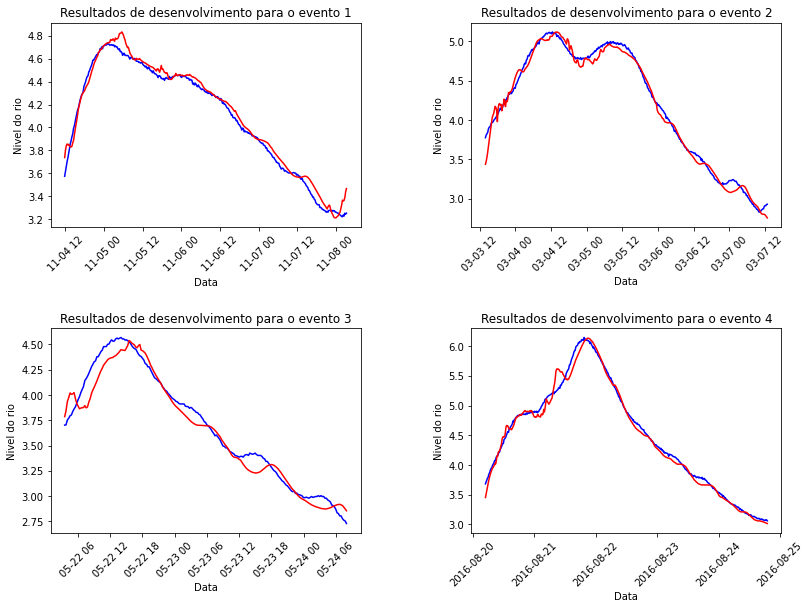

In [95]:
plot_lines = 2
plot_columns = 2
fig, ax = plt.subplots(plot_lines, plot_columns, figsize=(6.4*2, 4.8*2))
fig.tight_layout(pad=8)
initial_dev_offset = dev_event_offsets[0]
for line in range(plot_lines):
    for column in range(plot_columns):
        event = line * plot_columns + column
        ax[line, column].plot(dates[event_offsets[event+number_of_train_events]:event_offsets[event+number_of_train_events+1]], y_dev_3_hours[dev_event_offsets[event]-initial_dev_offset:dev_event_offsets[event+1]-initial_dev_offset], label='Verdadeiras medições', color='Blue')
        ax[line, column].plot(dates[event_offsets[event+number_of_train_events]:event_offsets[event+number_of_train_events+1]], dev_predictions[dev_event_offsets[event]-initial_dev_offset:dev_event_offsets[event+1]-initial_dev_offset], label='Medições previstas', color='Red')
        ax[line, column].set_title(f"Resultados de desenvolvimento para o evento {event+1}")
        ax[line, column].set_xlabel('Data')
        ax[line, column].tick_params(axis='x', rotation=45)
        ax[line, column].set_ylabel('Nivel do rio')

plt.show()

In [96]:
test_event_offsets = list(df_valid_data.where((df_valid_data.numero_evento > number_of_train_events + number_of_dev_events) & (df_valid_data.numero_evento <= number_of_train_events + number_of_dev_events + number_of_test_events)).reset_index().drop_duplicates('numero_evento',keep='first').index)[1:]

In [97]:
test_event_offsets

[13245, 13480]

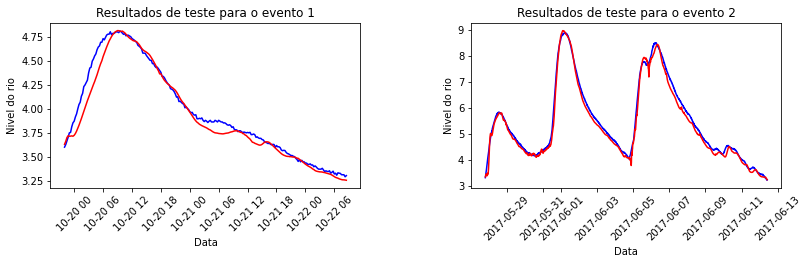

In [98]:
plot_lines = 1
plot_columns = 2
fig, ax = plt.subplots(plot_lines, plot_columns, figsize=(6.4*2, 4.8))
fig.tight_layout(pad=8)
initial_test_offset = test_event_offsets[0]
test_initial_offset = number_of_train_events + number_of_dev_events
for column in range(plot_columns):
    event = column
    if event == 1:
        ax[column].plot(dates[event_offsets[event+test_initial_offset]:event_offsets[event+test_initial_offset+1]], y_test_3_hours[test_event_offsets[event]-initial_test_offset:], label='Verdadeiras medições', color='Blue')
        ax[column].plot(dates[event_offsets[event+test_initial_offset]:event_offsets[event+test_initial_offset+1]], test_predictions[test_event_offsets[event]-initial_test_offset:], label='Medições previstas', color='Red')
    else:
        ax[column].plot(dates[event_offsets[event+test_initial_offset]:event_offsets[event+test_initial_offset+1]], y_test_3_hours[test_event_offsets[event]-initial_test_offset:test_event_offsets[event+1]-initial_test_offset], label='Verdadeiras medições', color='Blue')
        ax[column].plot(dates[event_offsets[event+test_initial_offset]:event_offsets[event+test_initial_offset+1]], test_predictions[test_event_offsets[event]-initial_test_offset:test_event_offsets[event+1]-initial_test_offset], label='Medições previstas', color='Red')
    ax[column].set_title(f"Resultados de teste para o evento {event+1}")
    ax[column].set_xlabel('Data')
    ax[column].tick_params(axis='x', rotation=45)
    ax[column].set_ylabel('Nivel do rio')

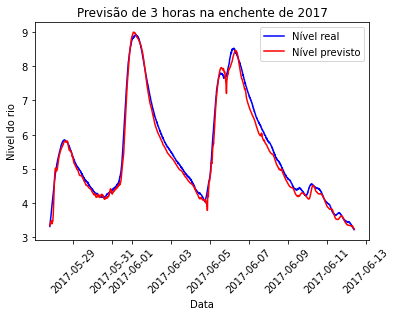

In [100]:
fig, ax = plt.subplots()
event = 1
ax.plot(dates[event_offsets[event+30]:event_offsets[event+30+1]], y_test_3_hours[test_event_offsets[event]-initial_test_offset:], label='Nível real', color='Blue')
ax.plot(dates[event_offsets[event+30]:event_offsets[event+30+1]], test_predictions[test_event_offsets[event]-initial_test_offset:], label='Nível previsto', color='Red')
ax.set_title("Previsão de 3 horas na enchente de 2017")
ax.set_xlabel('Data')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Nivel do rio')
plt.legend(loc="upper right")

In [101]:
TOP_ERROR_MARGIN = 0.05 # 5% de tolerância para erro acima do valor real
BOTTON_ERROR_MARGIN = -0.03 # 3% de tolerância para erro abaixo do valor real

In [102]:
def calc_acc(predictions, targets) -> float:
    acc_count = 0
    for prediction, target in zip(predictions, targets):
        prediction_error = ((prediction * 100 / target) - 100) / 100
        if BOTTON_ERROR_MARGIN <= prediction_error <= TOP_ERROR_MARGIN:
            acc_count += 1
        
    predictions_size = len(predictions)
    return round(acc_count/predictions_size, 4)

In [103]:
train_acc = calc_acc(train_predictions, y_train_3_hours)
print(f"Acurácia de treino para {HOURS_TO_PREDICT} horas: {round(train_acc*100, 2)}%")

dev_acc = calc_acc(dev_predictions, y_dev_3_hours)
print(f"Acurácia de desenvolvimento para {HOURS_TO_PREDICT} horas: {round(dev_acc*100, 2)}%")

test_acc = calc_acc(test_predictions, y_test_3_hours)
print(f"Acurácia de teste para {HOURS_TO_PREDICT} horas: {round(test_acc*100, 2)}%")


Acurácia de treino para 3 horas: 89.27%
Acurácia de desenvolvimento para 3 horas: 90.96%
Acurácia de teste para 3 horas: 72.97%


In [ ]:
# with open(result_dir + f"\\acuracia_{N_EPOCHS}_epochs_batch_size_{BATCH_SIZE}_dropout_{int(DROP_PROB*100)}.txt", 'w') as acc_file:
#     acc_file.write(f"Acurácia de treino para {HOURS_TO_PREDICT} horas: {round(train_acc*100, 2)}%")
#     acc_file.write('\n')
#     acc_file.write(f"Acurácia de desenvolvimento para {HOURS_TO_PREDICT} horas: {round(dev_acc*100, 2)}%")

In [ ]:
# model_path = result_dir + f"\\model_{N_EPOCHS}_epochs_batch_size_{BATCH_SIZE}_dropout_{int(DROP_PROB*100)}"
# torch.save(model_prediction.state_dict(), model_path)

In [83]:
save_model_path = "..\\results\\gru\\three_hours_prediction\\sequence_length\\97\\recurrent_layers\\1\hidden_units\\256\\learning_rate\\1e-05\\model_200_epochs_batch_size_32_dropout_25_amsgrad_0"
model_prediction.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>